In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import stats
from geopy.distance import great_circle
from scipy.stats.stats import pearsonr

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:

station = 'USW00013874'   
#station = 'USW00093009'
 
filename = '/Users/rphinney/Documents/Hollings/ghcnd_all/'+station+'.dly'
file = open(filename, 'r')


 ATLANTA HARTSFIELD INTL AP   
33.6300
 -84.4417 
odict_keys(['time', 'time_bounds', 'lon', 'lon_bounds', 'lat', 'lat_bounds', 'pr_above_99th'])
46752
46284


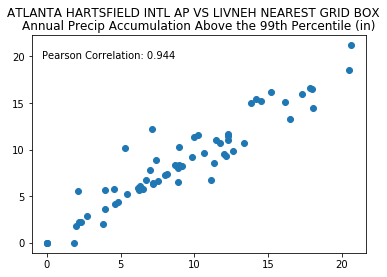

In [16]:

    
#Using ghcnd-stations.txt get the station information

path = '/Users/rphinney/Documents/Hollings/ghcnd-stations.txt'

station_file = open(path)
ghcnd = []

for x in station_file:
    ghcnd.append(x)

for each_line in ghcnd:   
    if each_line[0:11] == station:
        station_name = each_line[40:70]
        station_state = each_line[38:40]
        latitude = each_line[13:20]
        longitude = each_line[21:31]
        elevation = each_line[32:38]
        station_name.strip()
        print(station_name)
        print(latitude)
        print(longitude)
            
            
            
#------------------------------------------------------------------
#find nearest grid from the livneh file
    
filepath = '/Users/rphinney/Documents/Hollings/livneh_NAmerExt_15Oct2014_pr-above-99th_historical_1950_2013.nc'
data = Dataset(filepath)
    
lon = data.variables['lon'][:]
lat = data.variables['lat'][:]
print(data.variables.keys())
prcp = data.variables['pr_above_99th'][:]

            
station_loc = (latitude,longitude)
min_loc = 9999
    
for lons in lon:
    for lats in lat:
        check_loc = (lats,lons)
        b = int(great_circle(station_loc,check_loc).miles)
        if b < min_loc:
            min_loc = b
            min_lat = lats
            min_lon = lons-360

y = np.arange(1950,2014)           
#scatter plot the precip values at the grid nearest to the lincoln station
prcpa = []
lon_count = -1
lat_count = -1
for lons in lon:
    lon_count = lon_count +1
    if lons == min_lon+360:
        for lats in lat:
            lat_count = lat_count + 1
            if lats == min_lat:
                for x in range (0,64):
                    prcp2 = .03937*prcp[x,lat_count,lon_count]
                    prcpa.append(prcp2)
    
                    #plt.plot(y[x],.03937*prcp[x,lat_count,lon_count],'o', color = 'blue')


y = np.arange(1950,2014)
#plt.plot(y,prcpa,color = 'blue')

plt.title('Annual Precip Accumulation Above the 99th Percentile (in)')
plt.suptitle(station_name.strip() + ' VS LIVNEH NEAREST GRID BOX')


#---------------------------------------------------------------------------
#find the days above the 99th percentile from the GHCN station

begin_year = 1950
end_year = 2013

mylist = []

for line in file:
    mylist.append(line)

daymax = []
all_prcp = []
for year in range(1950,2014):
    year_prcp = []
    for line in mylist:
        if int(line[11:15]) == year:
            if line[17:21] == 'PRCP':
                year_prcp.append(line)

    new_prcp = []
    trace = []
    for data in year_prcp:
        char1 = 22
        char2 = 26
        while char1 != 270:
            if data[char1:char2] == '9999':
                char1 = char1 + 8
                char2 = char2 + 8
            else:
                prcp = (.003937*int(data[char1:char2]))      #convert to inches
                all_prcp.append(prcp)
                char1 = char1 + 8
                char2 = char2 + 8
all_prcp.extend(all_prcp)

# sort the data from smallest value to largest
all_prcp = sorted(all_prcp)

#find the percentile location
n_elements = size(all_prcp)
print(n_elements)

#Variable can be changed depending on which percentile is being used
percentile = .99

loc = round(percentile*n_elements)
print(loc)

# find the precipitation value at the percentile location
RRwn = (all_prcp[loc])


#find the number of days in which the precipitation amount was greater than the 99th percentile for a given year
#find the annual amount of precipitation when the daily amount is greater than the 99th percentile

days = []
annual = []

#range of years  ***add code to find this automatically
#find the first year

for year in range(1950,2014):
    year_prcp = []
    for line in mylist:
        if int(line[11:15]) == year:
            if line[17:21] == 'PRCP':
                year_prcp.append(line)
     
    new_prcp = []
    for data in year_prcp:
        char1 = 22
        char2 = 26
        while char1 != 270:
            if data[char1:char2] == '9999':
                char1 = char1 + 8
                char2 = char2 + 8
            else:
                prcp = (.003937*int(data[char1:char2])) 
                new_prcp.append(prcp)
                char1 = char1 + 8
                char2 = char2 + 8
                
    day_count = 0  
    annprcp = 0
    for one in new_prcp:
        if one > RRwn:
            day_count = 1 + day_count
            annprcp = one + annprcp
    
   
    days.append(day_count)
    annual.append(annprcp)
    
x = np.arange(1950,2013)
#plt.plot(x,daymax, color = 'red')


def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    return [float('nan') if x==0 else x for x in values]



plt.scatter(annual,prcpa)

pearson = pearsonr(annual,prcpa)
          
plt.figtext(.15,.8, 'Pearson Correlation: '+ str(round(pearson[0],3)))